<a href="https://colab.research.google.com/github/carturo6/Deep_Learning-Covid19/blob/main/LSTM_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I.A. DeepLearnin para Casos Covid-19

Este respositorio tiene el fin de predecir los proximo casos de Covid19 en México ( Nivel nacional ).

Los datos que se ocuparan, son los datos disponibles en paginas del Gobierno.
Se utilizaran solo tecnicas de Deep Learning donde cada modelo podra ir variando en funcion que los datos predichos mejor se ajusten a los datos predictorios.



## **Librerias**

In [176]:
# Import librarys.

# DC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# DL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

## **Importacion de datos**

In [177]:
# Carga del Dataset

df = pd.read_csv('/content/drive/MyDrive/IA_Projects/LSTM-Covid-19/owid-covid-data.csv')

In [178]:
# Seleccion a Mexico

df_mx = df[df['location'] == 'Mexico']

df_mx.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45393,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45394,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,97.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45395,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,186.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45396,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,231.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45397,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,316.0,0.002,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779


In [179]:
# Seleccionando columnas
df_mx = df_mx.iloc[:, 3:6]
df_mx.head()

,date,total_cases,new_cases
45393,2020-01-01,NaN,NaN
45394,2020-01-02,NaN,NaN
45395,2020-01-03,NaN,NaN
45396,2020-01-04,NaN,NaN
45397,2020-01-05,NaN,NaN


In [180]:
df_mx = df_mx.reset_index(inplace=False)

In [181]:
del df_mx['index']

In [182]:
# Trabajando con la columna de nuevos casos

df_mx = df_mx.iloc[:,[0,2]]

## **Transformacion de los datos**

In [183]:
df_mx.head(3)

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN


In [184]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       454 non-null    object 
 1   new_cases  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


In [185]:
df_mx.date = pd.to_datetime(df_mx.date)

In [186]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       454 non-null    datetime64[ns]
 1   new_cases  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 KB


In [187]:
df_mx.describe()

,new_cases
count,396.000000
mean,5625.866162
std,4475.211614
min,0.000000
25%,2800.250000
50%,5237.500000
75%,6848.500000
max,28115.000000


In [188]:
df_mx.isna().sum()

date          0
new_cases    58
dtype: int64

In [189]:
# Quitando Datos faltantes.

df_mx = df_mx[df_mx['new_cases'].notna()]

In [190]:
df_mx.tail()

,date,new_cases
449,2021-03-25,5787.0
450,2021-03-26,5303.0
451,2021-03-27,5059.0
452,2021-03-28,1646.0
453,2021-03-29,1293.0


In [191]:
df_mx.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     396
unique                    396
top       2020-04-13 00:00:00
freq                        1
first     2020-02-28 00:00:00
last      2021-03-29 00:00:00
Name: date, dtype: object

## **Visualizacion de Datos**

In [192]:
df_mx_2 = df_mx.copy()

In [193]:
df_mx_2.set_index('date', inplace=True)

In [201]:
# Promedio de ventanas de tiempo

#Ventana de tiempo
ventana_tiempo = df_mx_2.rolling(7)

#Media de la ventana de tiempo
media_df = ventana_tiempo.mean()

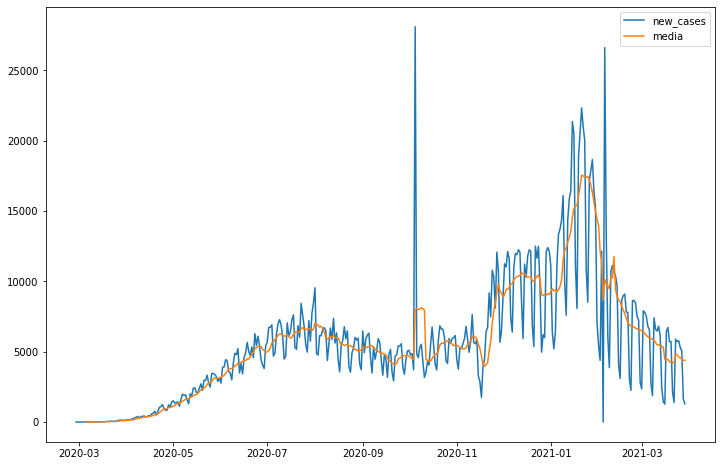

In [202]:
plt.figure(figsize=(12,8))
plt.plot(df_mx_2, label='new_cases')
plt.plot(media_df, label='media')
plt.legend()

In [196]:
seasonal_value = seasonal_decompose(df_mx_2, freq=7)

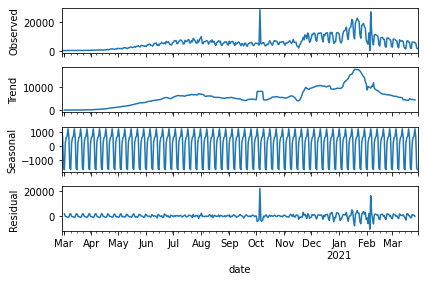

In [198]:
seasonal_value.plot();

# **Modelo-1**

In [218]:
# Datos de entreamiento y test

len(df_mx_2)

396

In [219]:
len(df_mx_2)-20

376

In [220]:
train = df_mx_2.iloc[:len(df_mx_2)-20]
test = df_mx_2.iloc[len(df_mx_2)-20:]

In [221]:
# Escalando datos

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler()

In [222]:
#Ajustando los datos de entrenamiento
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [223]:
#Datos escalados

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [224]:
# Generator
n_input = 20
n_feacture = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

x, y = generator[0]